In [8]:
import cv2
import os
from PIL import Image, ImageColor, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2gray, rgb2hsv
import cv2

In [9]:
from skimage.segmentation import felzenszwalb
from skimage import io, color
from skimage.segmentation import mark_boundaries

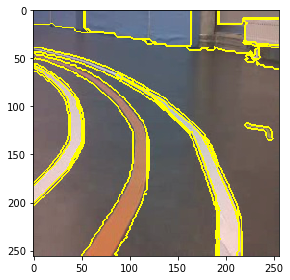

In [10]:
image_path = "1.jpg"
#image_path = "rec_001/2.jpg"
# image_path = "rec_001/3.jpg"
img = io.imread(image_path)
# segments = felzenszwalb(img, scale=500, sigma=0.5, min_size=50)
segments = felzenszwalb(img, scale=500, sigma=1, min_size=20)
io.imshow(mark_boundaries(img, segments))

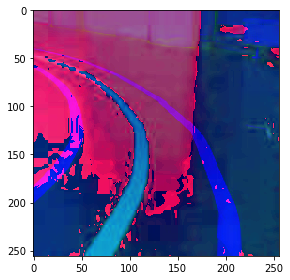

In [11]:
lower_white = [0, 0, 200] 
upper_white = [255, 30, 255]

lower_orange = [10, 100, 20]
upper_orange = [25, 255, 255]

# Convert image to HSV color space
hsv = rgb2hsv(img)
hsv = np.array(hsv * 255, dtype=np.uint8)
io.imshow(hsv)
    
    
# Define a threshold for similarity score
similarity_threshold = 1

# Iterate until no more segments can be concatenated
while True:
    # Compute the median color of each segment
    median_colors = []
    for i in np.unique(segments):
        mask = segments == i
        median_color = np.median(img[mask], axis=0)
        median_colors.append(median_color)

    # Compute similarity scores between adjacent segments
    similarity_scores = []
    for i in np.unique(segments):
        neighbors = np.unique(segments[felzenszwalb(img, scale=100, sigma=0.5, min_size=50) == i])
        for j in neighbors:
            if i < j:
                mask_i = segments == i
                mask_j = segments == j
                # if np.abs(np.median(img[mask_i], axis=0) - np.median(img[mask_j], axis=0)) < similarity_threshold:
                if np.all(np.abs(np.median(img[mask_i], axis=0) - np.median(img[mask_j], axis=0)) < similarity_threshold):
                    similarity_scores.append((i, j, np.abs(np.median(img[mask_i], axis=0) - np.median(img[mask_j], axis=0))))

    # If no similar segments found, break out of the loop
    if len(similarity_scores) == 0:
        break

    # Concatenate similar segments
    for score in similarity_scores:
        i, j, _ = score
        segments[segments == j] = i

# Apply color filter to identify white and orange lanes
white_mask = np.zeros_like(img, dtype=bool)
# white_mask[(img[:,:,0] > 200) & (img[:,:,1] > 200) & (img[:,:,2] > 200)] = True
white_mask[
    (hsv[:,:,0] >= lower_white[0]) & (hsv[:,:,0] <= upper_white[1]) & 
    (hsv[:,:,1] >= lower_white[1]) & (hsv[:,:,1] <= upper_white[1]) & 
    (hsv[:,:,2] >= lower_white[2]) & (hsv[:,:,2] <= upper_white[2]) 
] = True


white_segments = []
for i in np.unique(segments):
    mask = segments == i
    if np.sum(white_mask[mask]) > 0:
        white_segments.append(mask)

orange_mask = np.zeros_like(img, dtype=bool)
# orange_mask[(img[:,:,0] > 200) & (img[:,:,1] > 100) & (img[:,:,1] < 200) & (img[:,:,2] < 100)] = True
orange_mask[
    (hsv[:,:,0] >= lower_orange[0]) & (hsv[:,:,0] <= upper_orange[1]) & 
    (hsv[:,:,1] >= lower_orange[1]) & (hsv[:,:,1] <= upper_orange[1]) & 
    (hsv[:,:,2] >= lower_orange[2]) & (hsv[:,:,2] <= upper_orange[2]) 
] = True
orange_segments = []
for i in np.unique(segments):
    mask = segments == i
    if np.sum(orange_mask[mask]) > 0:
        orange_segments.append(mask)

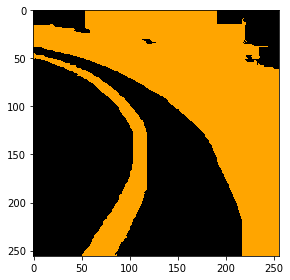

In [13]:
output_img = np.zeros_like(img)

# Set the pixels corresponding to white and orange lanes to white and orange colors, respectively
# for segment_mask in white_segments:
#   output_img[segment_mask] = [255, 255, 255]  # white color
for segment_mask in orange_segments:
    output_img[segment_mask] = [255, 165, 0]  # orange color
    
io.imshow(output_img)

In [84]:


def segment_lanes(image):
    # Convert image to HSV color space
    hsv = rgb2hsv(image)

    # Threshold image to isolate white and orange pixels
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([255, 30, 255])
    white_mask = cv2.inRange(hsv, lower_white, upper_white)

    lower_orange = np.array([10, 100, 20])
    upper_orange = np.array([25, 255, 255])
    orange_mask = cv2.inRange(hsv, lower_orange, upper_orange)

    # Combine masks to get a single lane mask
    lane_mask = cv2.bitwise_or(white_mask, orange_mask)

    # Apply the lane mask to the original image
    masked_image = cv2.bitwise_and(image, image, mask=lane_mask)

    # Convert masked image to grayscale
    gray = rgb2gray(masked_image)

    # Apply Felzenszwalb segmentation to the grayscale image
    segments = felzenszwalb(gray, scale=100, sigma=0.5, min_size=50)

    # Identify segments corresponding to lanes
    lane_segments = []
    for segment_val in np.unique(segments):
        segment_mask = segments == segment_val

        # Skip small segments
        if np.sum(segment_mask) < 100:
            continue

        # Compute median color of the segment
        median_color = np.median(image[segment_mask], axis=0)

        # Check if the segment is white or orange
        is_white = np.all(median_color > [220, 220, 220])
        is_orange = (median_color[0] > 150) and (median_color[0] < 255) and (median_color[1] > 50) and (median_color[2] < 200)

        # If the segment is white or orange, add it to the lane segments
        if is_white or is_orange:
            lane_segments.append(segment_mask)

    # Combine the lane segments into a single mask
    lane_mask = np.zeros_like(gray)
    for segment_mask in lane_segments:
        lane_mask = cv2.bitwise_or(lane_mask, segment_mask)

    print(lane_mask.shape)
    print(image.shape)
    
    return lane_mask
    # Apply the lane mask to the original image
    lane_image = cv2.bitwise_and(image, image, mask=lane_mask)

    return lane_image


In [43]:
img = io.imread(image_path)
lane_img = segment_lanes(img)

(256, 256)
(256, 256, 3)


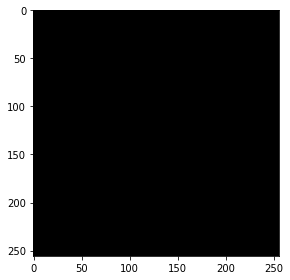

In [31]:
io.imshow(lane_img)